Acceleromter Stuff
====
Initial exploration

### Prerequisites
The right version of python and various packages and probably a GPU

### where the data is
I've copied a single accelerometer file into the `data/` directory to do this initial exploration.

This isn't a viable long-term solution, but downloading from RDSF takes forever

I've also mounted the RDSF files on my `Z:` drive - change this in `userconf.yaml` if you've done something different

One can also mount the files in the right place with
```
sudo mount -t cifs -o username=mh19137,workgroup=UOB //rdsfcifs.acrc.bris.ac.uk/SEACOCH20 /mnt/z/
```

### Choose a participant

In [1]:
device_id = "6012582"
recording_id = "0000291121"
participant_id = "20029"

In [2]:
# Find the accelerometer file
import pathlib

filename = f"{device_id}_{recording_id}-{participant_id}.cwa"
filepath = pathlib.Path(rf"data/{filename}")

# TODO add some code to look for the right files in all the "Week X" folders

assert filepath.exists()

In [3]:
""" Find the smartwatch data from the combined smartwatch file """
from ema import read, parse

meal_df = read.meal_info(participant_id)
allowed_meal_types = {"Snack", "Drink", "Meal", "No food/drink"}
meal_df = parse.extract_meals(meal_df, allowed_meal_types, verbose=True)

Discarding: {'Catch-up end': 1, 'Catch-up start': 1, 'No catch-up': 2, 'No response': 72}
Kept: {'Drink': 35, 'Meal': 37, 'No food/drink': 4, 'Snack': 2}


In [4]:
""" Read the accelerometry file """
samples = read.accel_info(str(filepath))

In [5]:
from pandas import Timedelta, to_datetime

# Find meal times
meal_times = meal_df["date"].map(str) + meal_df["timestamp"]

# Find an hour slot before each meal
ends = to_datetime(meal_times, format=r"%d%b%Y%H:%M:%S")
starts = ends - Timedelta(1, "hour")

5it [00:00, 16.86it/s]


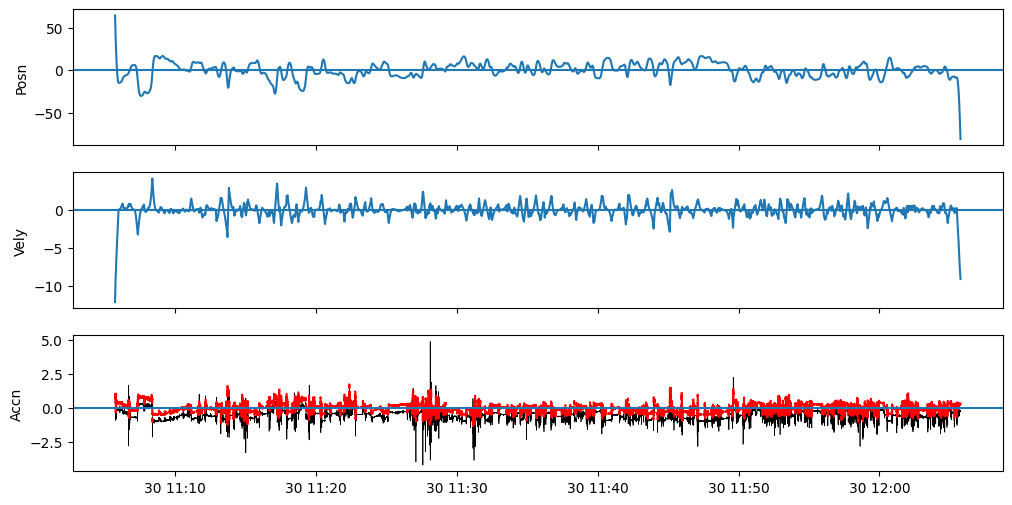

In [6]:
# To explore some of the time series...
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from ema import analysis, util

keep = meal_df["meal_type"] == "Meal"

for i, (start, end) in tqdm(enumerate(zip(starts[keep], ends[keep]))):
    # First few are empty
    if i < 5:
        continue

    slice = samples.loc[start:end]
    accel = slice["accel_x"]

    smoothed = analysis.smooth(accel, 10)

    smoothed = smoothed - np.mean(smoothed)

    # 100Hz => dx=0.01
    vely = analysis.integrate(smoothed, dx=1 / util.SAMPLE_RATE_HZ)
    vely -= np.mean(vely)

    # Smooth + then remove the smoothed curve
    smoothed_vely = analysis.smooth(vely, 30 * 100)
    vely -= smoothed_vely

    posn = analysis.integrate(vely, dx=0.01)
    posn -= np.mean(posn)

    fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True)

    axes[2].plot(slice.index, accel, linewidth=0.5, color="k")
    axes[2].plot(slice.index, smoothed, linewidth=1.5, linestyle="--", color="r")

    axes[1].plot(slice.index, vely)
    axes[0].plot(slice.index, posn)

    for axis, label, data in zip(axes, ("Posn", "Vely", "Accn"), (posn, vely, accel)):
        # axis.plot(samples[start:end].index, data)
        axis.set_ylabel(label)
        axis.axhline(0)

    break

0.008194252444396937


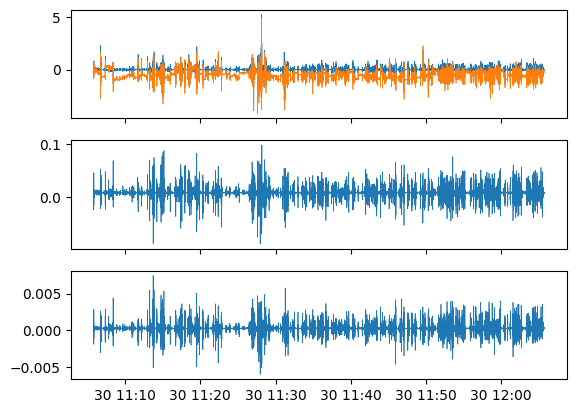

In [8]:
# FFT
from scipy import signal

accel = slice["accel_x"]

filter = signal.butter(2, 1, "hp", fs=100, output="sos")
filtered = signal.sosfiltfilt(filter, accel)

fig, ax = plt.subplots(3, 1, sharex=True)

kw = {"linewidth": 0.5}
ax[0].plot(slice.index, filtered, label="Filtered", **kw)
ax[0].plot(slice.index, accel, **kw)

vely = analysis.integrate(filtered, dx=0.01)
ax[1].plot(slice.index, vely, **kw)

print(np.mean(vely))

posn = analysis.integrate(signal.sosfiltfilt(filter, vely), dx=0.01)
ax[2].plot(slice.index, posn, **kw)

plt.show()

# fft = np.fft.rfft(accel)
# freqs = np.fft.rfftfreq(len(accel), d=1 / 100)
#
# power = np.abs(fft)
#
# plt.semilogy(freqs, power)
# plt.xlim(0, None)
# https://stackoverflow.com/questions/70131817/fourier-transform-time-series-in-python